In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/harik/Data science Assignment/monthly_milk_production.csv")
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [3]:
df.columns = ["Month", "Milk_Production"]

df["Month"] = pd.to_datetime(df["Month"])

df.set_index("Month", inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Milk_Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


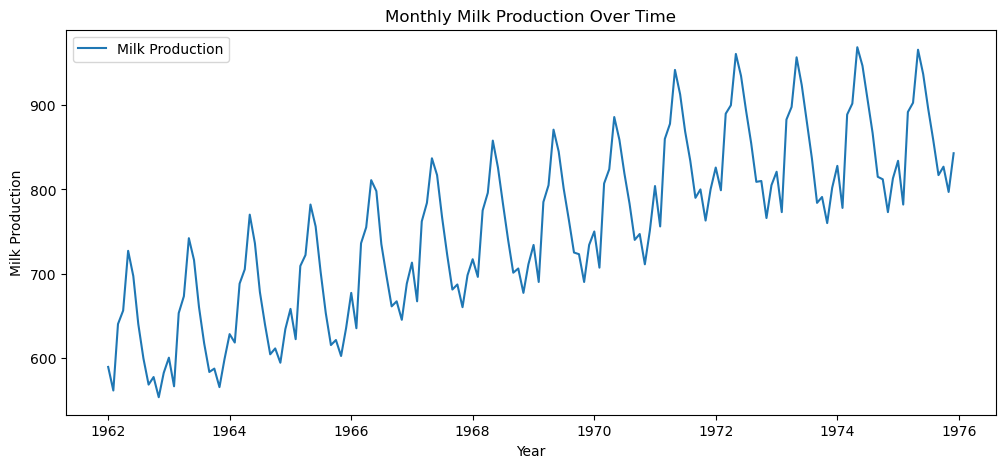

In [5]:
plt.figure(figsize=(12,5))
plt.plot(df, label="Milk Production")
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.legend()
plt.show()

In [6]:
print(df.isnull().sum())

Milk_Production    0
dtype: int64


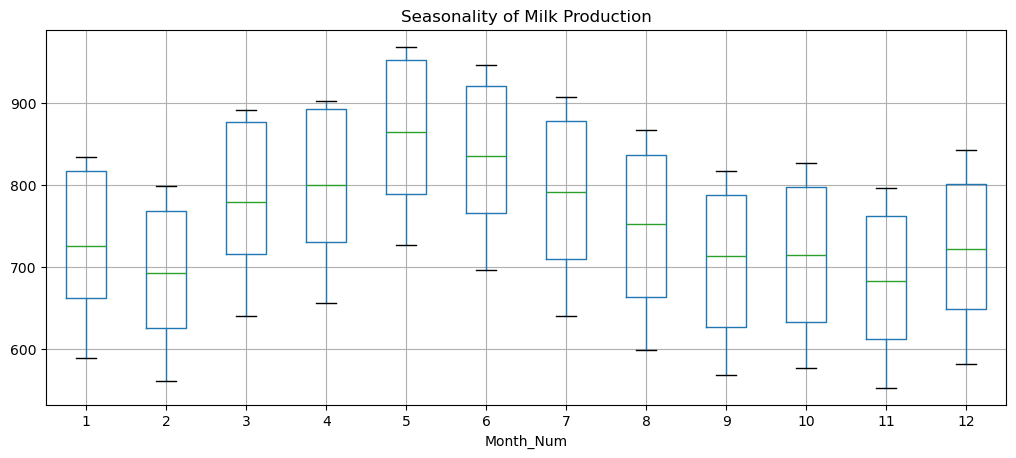

In [7]:
df['Month_Num'] = df.index.month
df.boxplot(column="Milk_Production", by="Month_Num", figsize=(12,5))
plt.title("Seasonality of Milk Production")
plt.suptitle("")
plt.show()

df.drop("Month_Num", axis=1, inplace=True)

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

In [11]:
def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW_SIZE = 12

X, y = create_sequences(scaled_data, WINDOW_SIZE)

X = X.reshape(X.shape[0], X.shape[1], 1)

In [12]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


In [13]:
def build_model(model_type):
    model = Sequential()
    
    if model_type == "RNN":
        model.add(SimpleRNN(50, activation="tanh", input_shape=(WINDOW_SIZE,1)))
    elif model_type == "LSTM":
        model.add(LSTM(50, activation="tanh", input_shape=(WINDOW_SIZE,1)))
    elif model_type == "GRU":
        model.add(GRU(50, activation="tanh", input_shape=(WINDOW_SIZE,1)))
    
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    
    return model


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
models = {}
histories = {}

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

for model_name in ["RNN", "LSTM", "GRU"]:
    print(f"\nTraining {model_name} model...")
    
    model = build_model(model_name)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )
    
    models[model_name] = model
    histories[model_name] = history



Training RNN model...
Epoch 1/100


C:\Users\harik\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.2586 - val_loss: 0.0245
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0590 - val_loss: 0.0184
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0181 - val_loss: 0.0603
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0192 - val_loss: 0.0415
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0067 - val_loss: 0.0131
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0055 - val_loss: 0.0133
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0049 - val_loss: 0.0095
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0039 - val_loss: 0.0085
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035 - val_loss: 0.0069
E

In [19]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(y_test.reshape(-1,1))
    
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    
    return rmse, mae, mape, actual, predictions


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


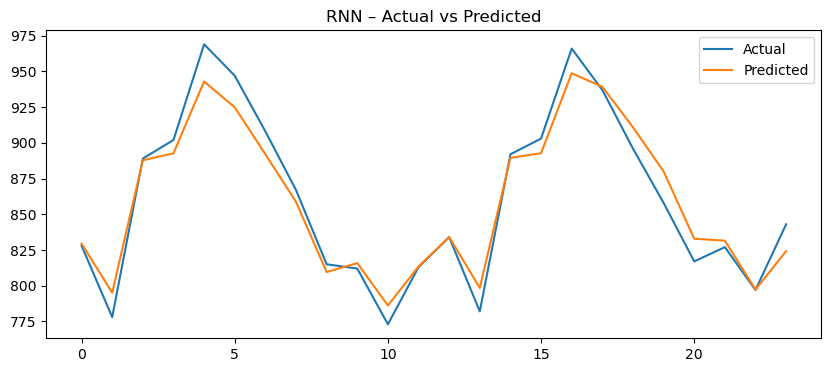

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


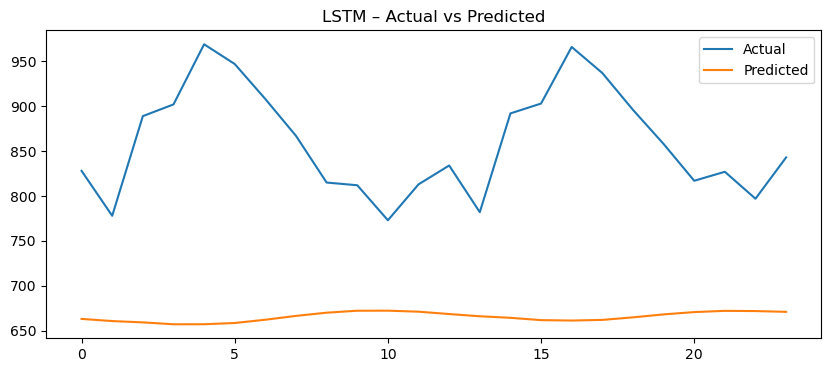

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


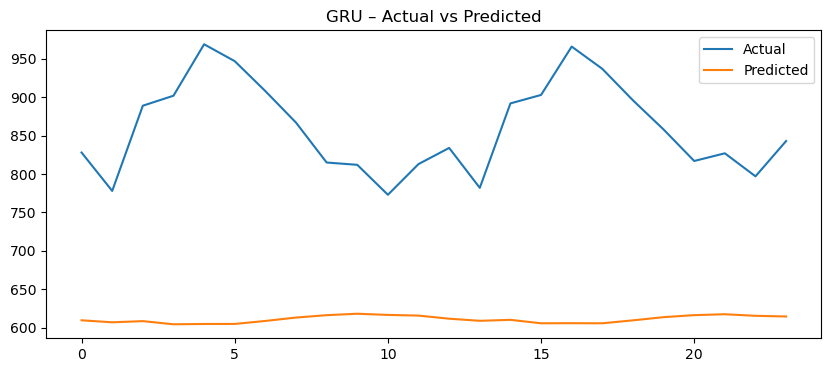

In [22]:
results = {}

for name, model in models.items():
    rmse, mae, mape, actual, pred = evaluate_model(model, X_test, y_test)
    results[name] = [rmse, mae, mape]
    
    plt.figure(figsize=(10,4))
    plt.plot(actual, label="Actual")
    plt.plot(pred, label="Predicted")
    plt.title(f"{name} – Actual vs Predicted")
    plt.legend()
    plt.show()

In [23]:
results_df = pd.DataFrame(results, index=["RMSE", "MAE", "MAPE"]).T
print(results_df)

            RMSE         MAE       MAPE
RNN    13.092452   10.402133   1.196966
LSTM  204.612340  194.979042  22.278957
GRU   257.160742  249.680677  28.668080


In [24]:
def forecast_future(model, last_sequence, months=12):
    forecast = []
    current_seq = last_sequence.copy()
    
    for _ in range(months):
        pred = model.predict(current_seq.reshape(1, WINDOW_SIZE, 1))
        forecast.append(pred[0,0])
        current_seq = np.append(current_seq[1:], pred)
    
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1,1))
    return forecast

In [25]:
best_model = models["LSTM"]

last_seq = scaled_data[-WINDOW_SIZE:]
future_forecast = forecast_future(best_model, last_seq, 12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\harik\AppData\Local\Temp\ipykernel_436\3232856916.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


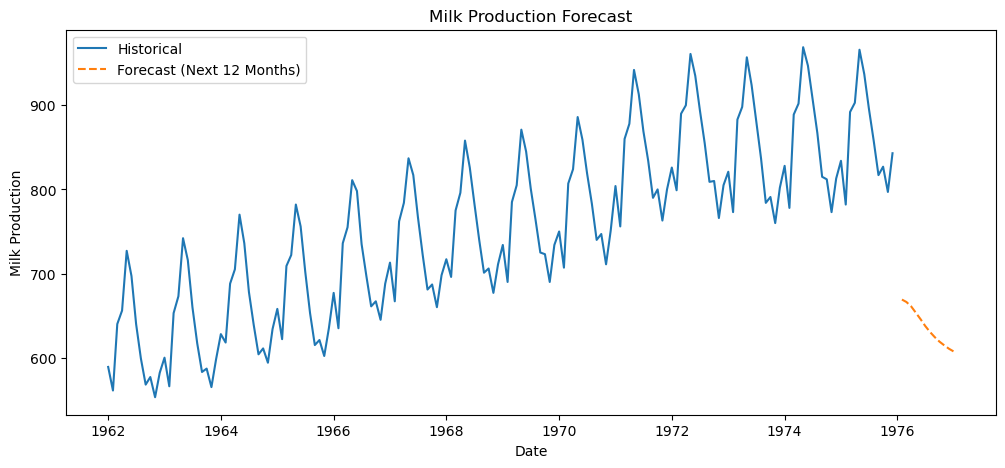

In [26]:
future_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

plt.figure(figsize=(12,5))
plt.plot(df.index, df["Milk_Production"], label="Historical")
plt.plot(future_dates, future_forecast, label="Forecast (Next 12 Months)", linestyle="--")
plt.title("Milk Production Forecast")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.legend()
plt.show()